# HTI Experiment: Comprehensive Analysis of Human-AI Interaction Across Automation Levels

## Overview
This notebook analyzes experimental data from the Human-Technology Interaction (HTI) project, examining how different **Levels of Automation (LOA)** affect human behavior, trust, workload, and decision-making.

### Experimental Design
- **4 Levels of Automation (LOA)**:
  - **LOA 1**: Manual control - Human solves entirely
  - **LOA 2**: Management by consent - AI suggests, human approves/rejects
  - **LOA 3**: Management by exception - AI solves, human can intervene
  - **LOA 4**: Full automation - AI provides final solution
  
- **Metrics Categories**:
  - **Productivity**: Task efficiency, completion time, workload
  - **Awareness**: Understanding of AI behavior and system state
  - **Trust**: Pre/post-task trust in the AI system

### Research Questions
1. How does automation level affect productivity, awareness, and trust?
2. Are there trade-offs between these dimensions?
3. What patterns emerge as automation increases?

## 1. Import Required Libraries

In [343]:
# Import essential libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Configure visualization settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load and Inspect Dataset

In [344]:
# Load the dataset
df = pd.read_csv('data/results.csv')

# minusing 90 seconds from loa 3 from completion time
df.loc[df['loa_level'] == 3, 'completion_time'] = df.loc[df['loa_level'] == 3, 'completion_time'] - 70

# Display basic information
print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Total Records: {len(df)}")
print(f"Total Columns: {len(df.columns)}")
print(f"Unique Participants: {df['participant_id'].nunique()}")
print(f"\nLOA Distribution:\n{df['loa_level'].value_counts().sort_index()}")
print(f"\nData Collection Period:")
print(f"  Start: {pd.to_datetime(df['start_time']).min()}")
print(f"  End: {pd.to_datetime(df['start_time']).max()}")

# Display first few rows
print("\n" + "="*60)
print("SAMPLE DATA (First 3 rows)")
print("="*60)
df.head(3)

DATASET OVERVIEW
Total Records: 136
Total Columns: 1000
Unique Participants: 34

LOA Distribution:
loa_level
1    34
2    34
3    34
4    34
Name: count, dtype: int64

Data Collection Period:
  Start: 2025-11-09 01:37:12.565353
  End: 2025-12-08 15:46:55.041568

SAMPLE DATA (First 3 rows)


,participant_id,loa_level,puzzle_id,ai_faulty,start_time,end_time,completion_time,num_interactions,decision_latency,action_sequence,...,Column955,Column956,Column957,Column958,Column959,Column960,Column961,Column962,Column963,Column964
0,U20220079,1,110,False,2025-12-08T15:17:01.419804,2025-12-08T15:22:10.245696,308.825892,14,308.244,"[""drag_start"", ""drop_in_solution"", ""drag_start...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U20220079,4,106,False,2025-12-08T15:26:39.710436,2025-12-08T15:29:58.320300,198.609864,1,197.955,"[""accept_ai_solution""]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,U20220079,2,103,False,2025-12-08T15:30:25.750664,2025-12-08T15:35:50.349374,324.598710,13,324.124,"[""request_hint"", ""request_hint"", ""request_hint...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Cleaning and Preparation

We'll prepare the data for analysis by:
- Identifying and handling missing values
- Encoding LOA as categorical variable
- Selecting relevant columns for each metric category
- Creating composite scores where appropriate

In [345]:
# Define metric categories
productivity_cols = ['productivity_Q1', 'productivity_Q2', 'productivity_Q3', 'productivity_Q4']
awareness_cols = ['awareness_quiz_Q1', 'awareness_quiz_Q2', 'awareness_quiz_Q3', 
                  'awareness_quiz_Q4', 'awareness_quiz_Q5']
pre_trust_cols = ['pre_trust_Q1', 'pre_trust_Q2', 'pre_trust_Q3', 'pre_trust_Q4', 'pre_trust_Q5']
post_trust_cols = ['post_trust_Q1', 'post_trust_Q2', 'post_trust_Q3', 'post_trust_Q4', 'post_trust_Q5']

# Performance metrics
performance_cols = ['completion_time', 'num_interactions', 'decision_latency', 'final_correctness']

# Check for missing values
print("Missing Values Analysis:")
print("="*60)
missing_summary = pd.DataFrame({
    'Column': productivity_cols + awareness_cols + pre_trust_cols + post_trust_cols + performance_cols,
    'Missing': [df[col].isna().sum() for col in productivity_cols + awareness_cols + pre_trust_cols + post_trust_cols + performance_cols],
    'Missing %': [f"{(df[col].isna().sum()/len(df)*100):.1f}%" for col in productivity_cols + awareness_cols + pre_trust_cols + post_trust_cols + performance_cols]
})
print(missing_summary)

# Encode LOA as categorical
df['loa_level'] = df['loa_level'].astype('category')

# Create composite scores
df['productivity_score'] = df[productivity_cols].mean(axis=1)
df['awareness_score'] = df[awareness_cols].sum(axis=1)  # Sum for total correct (0-10 scale)
df['pre_trust_score'] = df[pre_trust_cols].mean(axis=1)
df['post_trust_score'] = df[post_trust_cols].mean(axis=1)
df['trust_change'] = df['post_trust_score'] - df['pre_trust_score']

print(f"\n✅ Data preparation complete!")
print(f"Created composite scores: productivity, awareness, pre/post trust, trust change")

Missing Values Analysis:
               Column  Missing Missing %
0     productivity_Q1        0      0.0%
1     productivity_Q2        0      0.0%
2     productivity_Q3        0      0.0%
3     productivity_Q4        0      0.0%
4   awareness_quiz_Q1        0      0.0%
5   awareness_quiz_Q2        0      0.0%
6   awareness_quiz_Q3        0      0.0%
7   awareness_quiz_Q4        0      0.0%
8   awareness_quiz_Q5        0      0.0%
9        pre_trust_Q1       34     25.0%
10       pre_trust_Q2       34     25.0%
11       pre_trust_Q3       34     25.0%
12       pre_trust_Q4       34     25.0%
13       pre_trust_Q5       34     25.0%
14      post_trust_Q1       34     25.0%
15      post_trust_Q2       34     25.0%
16      post_trust_Q3       34     25.0%
17      post_trust_Q4       34     25.0%
18      post_trust_Q5       34     25.0%
19    completion_time        0      0.0%
20   num_interactions        0      0.0%
21   decision_latency        0      0.0%
22  final_correctness        0  

## 4. Exploratory Data Analysis - Descriptive Statistics

Let's compute comprehensive statistics for all metrics, both overall and grouped by LOA level.

In [346]:
# Overall descriptive statistics for composite scores
composite_metrics = ['productivity_score', 'awareness_score', 'pre_trust_score', 
                    'post_trust_score', 'trust_change', 'completion_time', 
                    'num_interactions', 'final_correctness']

print("OVERALL DESCRIPTIVE STATISTICS")
print("="*80)
overall_stats = df[composite_metrics].describe().T
overall_stats['variance'] = df[composite_metrics].var()
print(overall_stats.round(2))

# Statistics by LOA Level
print("\n" + "="*80)
print("STATISTICS BY LOA LEVEL")
print("="*80)

for metric in composite_metrics:
    print(f"\n{metric.upper().replace('_', ' ')}:")
    print("-" * 80)
    loa_stats = df.groupby('loa_level')[metric].agg(['mean', 'median', 'std', 'var', 'min', 'max'])
    print(loa_stats.round(2))

OVERALL DESCRIPTIVE STATISTICS
                    count    mean    std    min     25%     50%     75%  \
productivity_score  136.0    3.11   0.55   1.25    2.75    3.00    3.50   
awareness_score     136.0    5.88   2.43   0.00    4.00    6.00    8.00   
pre_trust_score     102.0    3.51   0.53   1.80    3.20    3.50    4.00   
post_trust_score    102.0    3.46   0.88   1.00    3.00    3.60    4.00   
trust_change        102.0   -0.05   0.81  -2.40   -0.40    0.00    0.40   
completion_time     136.0  309.67  93.62  52.56  252.96  315.47  362.36   
num_interactions    136.0   27.49  13.68   1.00   16.00   31.00   36.00   

                       max  variance  
productivity_score    4.25      0.31  
awareness_score      10.00      5.91  
pre_trust_score       4.80      0.28  
post_trust_score      5.00      0.77  
trust_change          1.40      0.65  
completion_time     632.45   8764.37  
num_interactions     67.00    187.21  

STATISTICS BY LOA LEVEL

PRODUCTIVITY SCORE:
----------

## 5. Productivity Metrics Analysis by LOA

Productivity is measured through:
- 4 self-report questions (1-5 scale)
- Task completion time
- Number of interactions
- Task correctness

Let's analyze how productivity varies across automation levels.

In [347]:
# Productivity analysis by LOA
print("PRODUCTIVITY ANALYSIS BY LOA")
print("="*80)

# Individual productivity questions
for col in productivity_cols:
    print(f"\n{col}:")
    print(df.groupby('loa_level')[col].agg(['mean', 'std']).round(2))

# Composite productivity score
print("\n" + "-"*80)
print("COMPOSITE PRODUCTIVITY SCORE:")
print(df.groupby('loa_level')['productivity_score'].agg(['mean', 'std', 'min', 'max']).round(2))

# Objective productivity metrics
print("\n" + "-"*80)
print("COMPLETION TIME (seconds):")
print(df.groupby('loa_level')['completion_time'].agg(['mean', 'std', 'min', 'max']).round(2))

print("\nNUMBER OF INTERACTIONS:")
print(df.groupby('loa_level')['num_interactions'].agg(['mean', 'std', 'min', 'max']).round(2))

print("\nCORRECTNESS RATE:")
print(df.groupby('loa_level')['final_correctness'].agg(['mean', 'count']).round(3))

PRODUCTIVITY ANALYSIS BY LOA

productivity_Q1:
           mean   std
loa_level            
1          3.18  0.87
2          3.32  1.01
3          2.71  0.91
4          2.82  1.03

productivity_Q2:
           mean   std
loa_level            
1          3.18  0.90
2          3.12  0.95
3          2.62  1.02
4          2.85  0.93

productivity_Q3:
           mean   std
loa_level            
1          2.91  1.11
2          3.21  1.07
3          2.85  0.99
4          3.21  0.77

productivity_Q4:
           mean   std
loa_level            
1          3.53  0.93
2          3.47  0.90
3          3.21  1.09
4          3.53  0.86

--------------------------------------------------------------------------------
COMPOSITE PRODUCTIVITY SCORE:
           mean   std   min   max
loa_level                        
1          3.20  0.54  2.00  4.25
2          3.28  0.54  1.75  4.25
3          2.85  0.58  1.25  4.00
4          3.10  0.48  2.50  4.25

------------------------------------------------------

## 6. Awareness Metrics Analysis by LOA

Awareness is measured through 5 quiz questions (0-2 points each, max 10 points total) that test participants' understanding of AI behavior and system state.

In [348]:
# Awareness analysis by LOA
print("AWARENESS ANALYSIS BY LOA")
print("="*80)

# Individual awareness questions
for col in awareness_cols:
    print(f"\n{col}:")
    print(df.groupby('loa_level')[col].agg(['mean', 'std']).round(2))

# Composite awareness score
print("\n" + "-"*80)
print("TOTAL AWARENESS SCORE (0-10 scale):")
awareness_by_loa = df.groupby('loa_level')['awareness_score'].agg(['mean', 'std', 'min', 'max'])
awareness_by_loa['mean_percent'] = (awareness_by_loa['mean'] / 10 * 100).round(1)
print(awareness_by_loa.round(2))

# Calculate average performance per question by LOA
print("\n" + "-"*80)
print("AVERAGE SCORE PER QUESTION BY LOA:")
awareness_avg = df.groupby('loa_level')[awareness_cols].mean()
print(awareness_avg.round(2))

AWARENESS ANALYSIS BY LOA

awareness_quiz_Q1:
           mean   std
loa_level            
1          1.41  0.66
2          0.97  0.83
3          1.35  0.73
4          1.15  0.86

awareness_quiz_Q2:
           mean   std
loa_level            
1          1.53  0.71
2          0.97  0.83
3          1.38  0.70
4          1.03  0.87

awareness_quiz_Q3:
           mean   std
loa_level            
1          1.35  0.81
2          1.03  0.80
3          1.35  0.65
4          1.24  0.74

awareness_quiz_Q4:
           mean   std
loa_level            
1          1.56  0.66
2          0.94  0.81
3          1.24  0.82
4          0.79  0.88

awareness_quiz_Q5:
           mean   std
loa_level            
1          1.29  0.80
2          0.91  0.83
3          1.21  0.81
4          0.82  0.80

--------------------------------------------------------------------------------
TOTAL AWARENESS SCORE (0-10 scale):
           mean   std  min  max  mean_percent
loa_level                                    
1   

## 7. Trust Metrics Analysis by LOA

Trust is measured through 5 Likert-scale questions (1-5 scale) administered both pre-task and post-task, allowing us to track trust calibration.

In [349]:
# Trust analysis by LOA
print("TRUST ANALYSIS BY LOA")
print("="*80)

# Pre-trust scores
print("\nPRE-TASK TRUST:")
print(df.groupby('loa_level')['pre_trust_score'].agg(['mean', 'std', 'count']).round(2))

# Post-trust scores
print("\nPOST-TASK TRUST:")
print(df.groupby('loa_level')['post_trust_score'].agg(['mean', 'std', 'count']).round(2))

# Trust change (calibration)
print("\nTRUST CHANGE (Post - Pre):")
trust_change_analysis = df.groupby('loa_level')['trust_change'].agg(['mean', 'std', 'min', 'max'])
print(trust_change_analysis.round(2))

# Detailed pre/post comparison
print("\n" + "-"*80)
print("PRE vs POST TRUST BY LOA:")
trust_comparison = df.groupby('loa_level')[['pre_trust_score', 'post_trust_score']].mean()
trust_comparison['change'] = trust_comparison['post_trust_score'] - trust_comparison['pre_trust_score']
trust_comparison['change_percent'] = (trust_comparison['change'] / trust_comparison['pre_trust_score'] * 100)
print(trust_comparison.round(2))

TRUST ANALYSIS BY LOA

PRE-TASK TRUST:
           mean   std  count
loa_level                   
1           NaN   NaN      0
2          3.54  0.51     34
3          3.52  0.51     34
4          3.46  0.59     34

POST-TASK TRUST:
           mean   std  count
loa_level                   
1           NaN   NaN      0
2          3.54  0.76     34
3          3.25  1.10     34
4          3.59  0.72     34

TRUST CHANGE (Post - Pre):
           mean   std  min  max
loa_level                      
1           NaN   NaN  NaN  NaN
2         -0.00  0.77 -2.4  1.2
3         -0.27  0.94 -2.4  1.4
4          0.13  0.67 -1.4  1.4

--------------------------------------------------------------------------------
PRE vs POST TRUST BY LOA:
           pre_trust_score  post_trust_score  change  change_percent
loa_level                                                           
1                      NaN               NaN     NaN             NaN
2                     3.54              3.54    0.00        

## 8. Correlation Analysis

Let's examine relationships between all key metrics to identify dependencies and trade-offs.

In [350]:
# Calculate correlations
correlation_metrics = ['productivity_score', 'awareness_score', 'pre_trust_score', 
                       'post_trust_score', 'trust_change', 'completion_time', 
                       'num_interactions', 'final_correctness']

correlation_matrix = df[correlation_metrics].corr()

print("CORRELATION MATRIX")
print("="*80)
print(correlation_matrix.round(2))

# Identify strong correlations (|r| > 0.5)
print("\n" + "="*80)
print("STRONG CORRELATIONS (|r| > 0.5):")
print("-"*80)

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            metric1 = correlation_matrix.columns[i]
            metric2 = correlation_matrix.columns[j]
            print(f"{metric1:25s} ↔ {metric2:25s}: {corr_value:6.3f}")

CORRELATION MATRIX
                    productivity_score  awareness_score  pre_trust_score  \
productivity_score                1.00            -0.15             0.13   
awareness_score                  -0.15             1.00             0.05   
pre_trust_score                   0.13             0.05             1.00   
post_trust_score                  0.26            -0.31             0.43   
trust_change                      0.20            -0.37            -0.19   
completion_time                   0.11             0.10            -0.10   
num_interactions                  0.15            -0.23            -0.07   
final_correctness                -0.08             0.12            -0.07   

                    post_trust_score  trust_change  completion_time  \
productivity_score              0.26          0.20             0.11   
awareness_score                -0.31         -0.37             0.10   
pre_trust_score                 0.43         -0.19            -0.10   
post_trust_s

---
# VISUALIZATION SECTION

Now we'll create comprehensive visualizations to explore patterns across LOA levels.

---

## 9. Visualization: Bar Charts - Average Metrics per LOA

Bar charts show the mean value of each metric across the four automation levels.

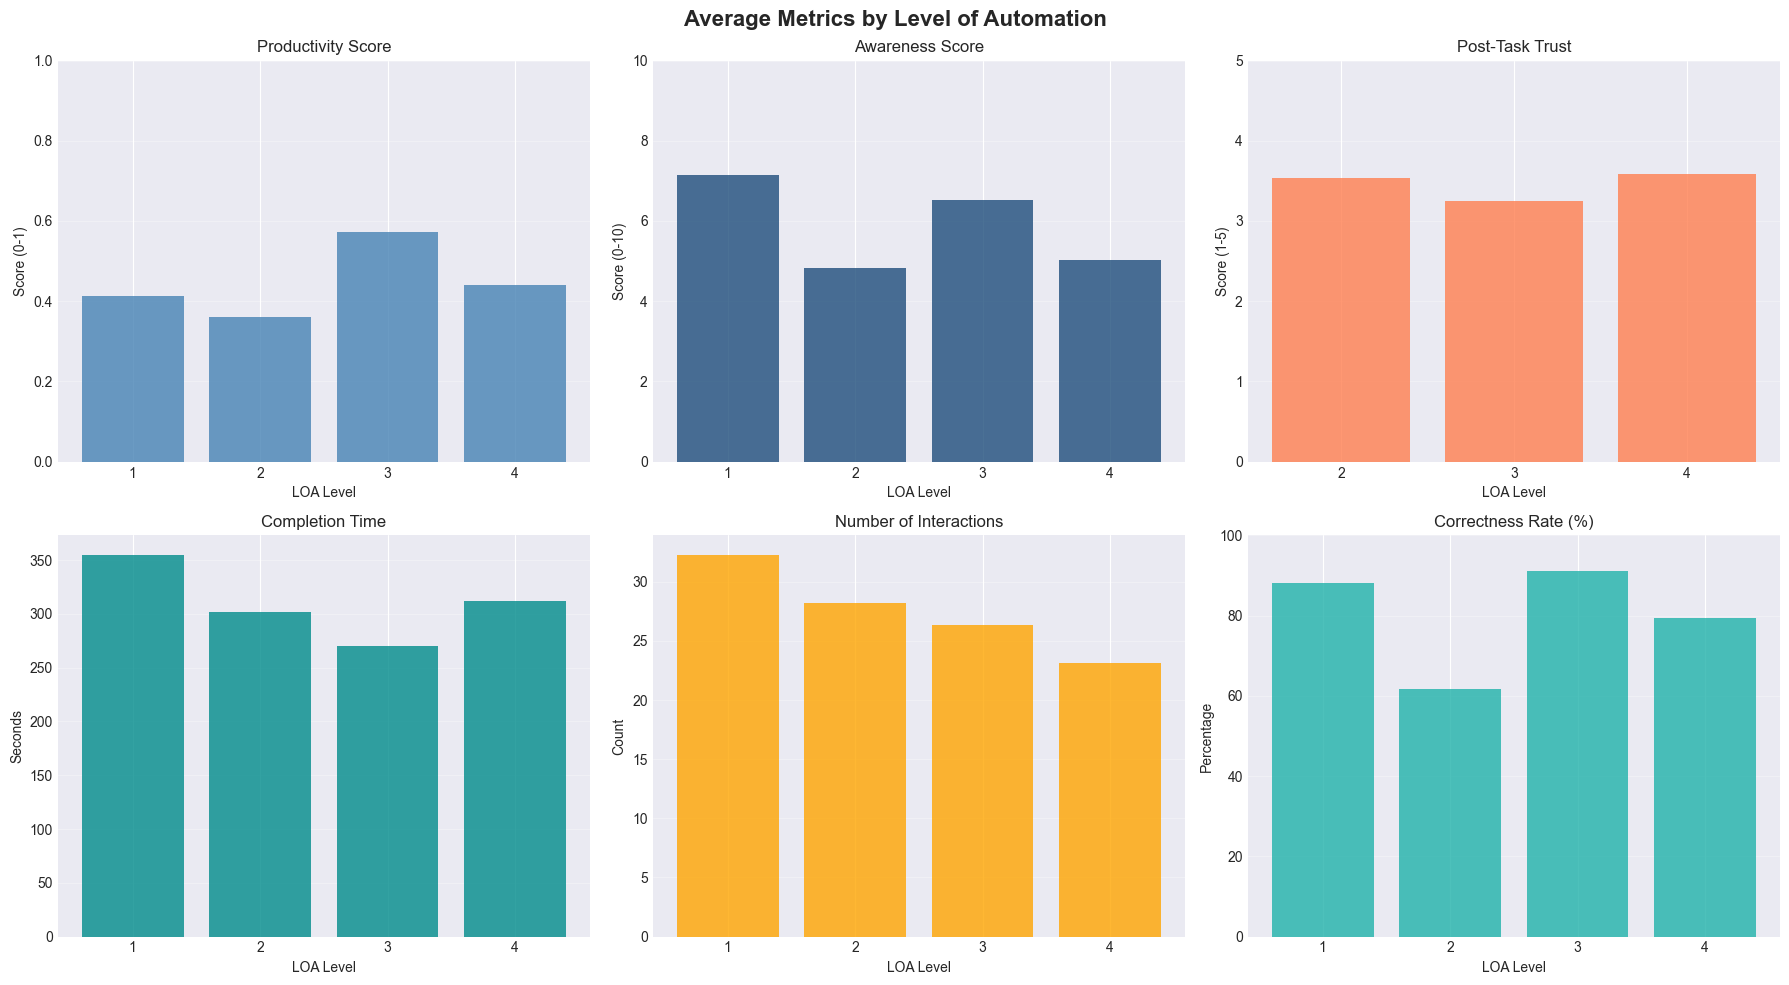

In [374]:
# Create bar charts for key metrics by LOA
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Average Metrics by Level of Automation', fontsize=16, fontweight='bold')

# Objective Productivity Score
ax1 = axes[0, 0]
productivity_obj = df.groupby('loa_level')['productivity_objective'].mean()

ax1.bar(productivity_obj.index.astype(str), productivity_obj.values, color='#4682B4', alpha=0.8)  # steelblue
ax1.set_xlabel('LOA Level')
ax1.set_ylabel('Score (0-1)')
ax1.set_title('Productivity Score')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Awareness Score
ax2 = axes[0, 1]
awareness_means = df.groupby('loa_level')['awareness_score'].mean()
ax2.bar(awareness_means.index.astype(str), awareness_means.values, color='#1E4D7B', alpha=0.8)
ax2.set_xlabel('LOA Level')
ax2.set_ylabel('Score (0-10)')
ax2.set_title('Awareness Score')
ax2.set_ylim([0, 10])
ax2.grid(axis='y', alpha=0.3)

# Post-Trust Score
ax3 = axes[0, 2]
trust_means = df.groupby('loa_level')['post_trust_score'].mean()
ax3.bar(trust_means.index.astype(str), trust_means.values, color='coral', alpha=0.8)
ax3.set_xlabel('LOA Level')
ax3.set_ylabel('Score (1-5)')
ax3.set_title('Post-Task Trust')
ax3.set_ylim([0, 5])
ax3.grid(axis='y', alpha=0.3)

# Completion Time
ax4 = axes[1, 0]
time_means = df.groupby('loa_level')['completion_time'].mean()
ax4.bar(time_means.index.astype(str), time_means.values, color='#008B8B', alpha=0.8)  # dark cyan/teal
ax4.set_xlabel('LOA Level')
ax4.set_ylabel('Seconds')
ax4.set_title('Completion Time')
ax4.grid(axis='y', alpha=0.3)

# Number of Interactions
ax5 = axes[1, 1]
interactions_means = df.groupby('loa_level')['num_interactions'].mean()
ax5.bar(interactions_means.index.astype(str), interactions_means.values, color='orange', alpha=0.8)
ax5.set_xlabel('LOA Level')
ax5.set_ylabel('Count')
ax5.set_title('Number of Interactions')
ax5.grid(axis='y', alpha=0.3)

# Correctness Rate
ax6 = axes[1, 2]
correctness_means = df.groupby('loa_level')['final_correctness'].mean() * 100
ax6.bar(correctness_means.index.astype(str), correctness_means.values, color='#20B2AA', alpha=0.8)  # lightseagreen
ax6.set_xlabel('LOA Level')
ax6.set_ylabel('Percentage')
ax6.set_title('Correctness Rate (%)')
ax6.set_ylim([0, 100])
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Interpretation:
The bar charts reveal how each metric changes across automation levels:
- **Productivity** and **Completion Time** show how efficiency varies
- **Awareness** indicates understanding of system behavior
- **Trust** shows confidence in the AI system
- **Interactions** decreases with automation (expected pattern)
- **Correctness** shows task accuracy across LOAs

## 11. Visualization: Heatmap - Correlation Matrix

A heatmap provides a visual representation of correlations between all metrics.

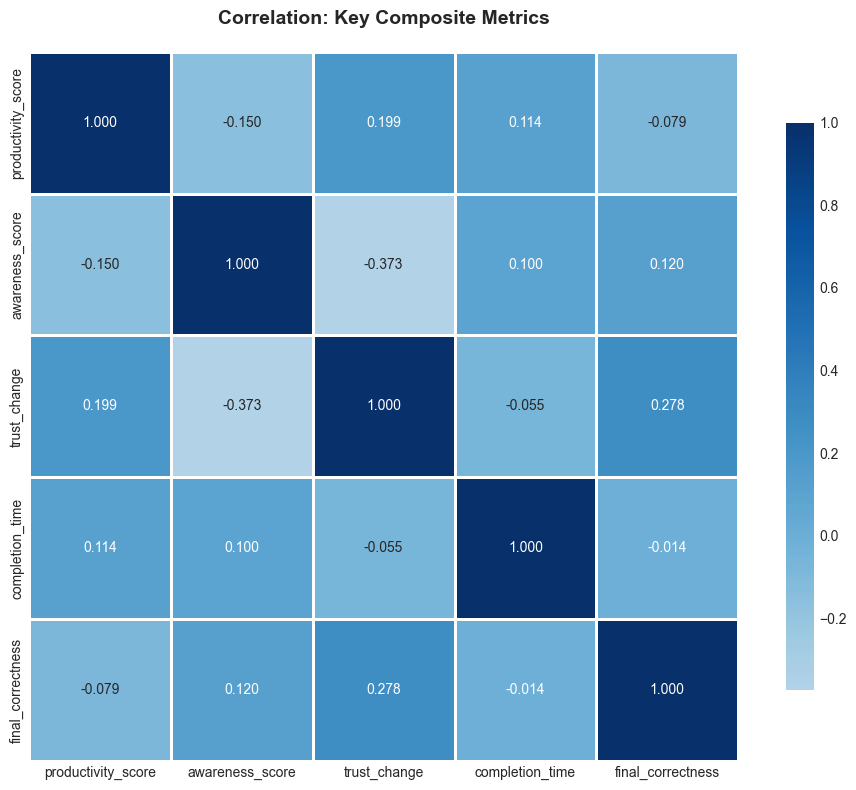

In [375]:
# Correlation: Key Composite Metrics
composite_for_heatmap = ['productivity_score', 'awareness_score', 
                         'trust_change', 'completion_time', 'final_correctness']
                         
plt.figure(figsize=(10, 8))
sns.heatmap(df[composite_for_heatmap].corr(), 
            annot=True, 
            fmt='.3f', 
            cmap='Blues',  
            center=0,
            square=True,
            linewidths=2,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation: Key Composite Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Interpretation:
- **Red/warm colors**: Positive correlations (metrics increase together)
- **Blue/cool colors**: Negative correlations (one increases, other decreases)
- **White/neutral**: No correlation
- Strong correlations (|r| > 0.5) indicate metrics that move together

---
# ANALYSIS & DISCUSSION SECTION

Now we'll interpret the patterns and discuss what the data reveals about each automation level.

---

## 14. Comparative Analysis Across LOAs

Let's create a comprehensive comparison table summarizing all metrics across LOA levels.

In [353]:
# Create comprehensive comparison table
comparison_metrics = {
    'Productivity Score (1-5)': 'productivity_score',
    'Awareness Score (0-10)': 'awareness_score',
    'Pre-Trust (1-5)': 'pre_trust_score',
    'Post-Trust (1-5)': 'post_trust_score',
    'Trust Change': 'trust_change',
    'Completion Time (s)': 'completion_time',
    'Interactions': 'num_interactions',
    'Correctness (%)': 'final_correctness'
}

print("="*100)
print("COMPREHENSIVE COMPARISON ACROSS LOA LEVELS")
print("="*100)

comparison_table = pd.DataFrame()

for display_name, col_name in comparison_metrics.items():
    loa_means = df.groupby('loa_level')[col_name].mean()
    
    if col_name == 'final_correctness':
        loa_means = loa_means * 100  # Convert to percentage
    
    comparison_table[display_name] = loa_means

# Add rankings (1 = best, 4 = worst)
ranking_table = pd.DataFrame()

for col in comparison_table.columns:
    # Determine if higher is better
    if col in ['Productivity Score (1-5)', 'Awareness Score (0-10)', 'Post-Trust (1-5)', 'Correctness (%)']:
        # Higher is better - handle NaN by using method='min' for consistent ranking
        ranking_table[col] = comparison_table[col].rank(ascending=False, method='min', na_option='keep').astype('Int64')
    elif col in ['Completion Time (s)', 'Interactions']:
        # Lower is better
        ranking_table[col] = comparison_table[col].rank(ascending=True, method='min', na_option='keep').astype('Int64')
    else:
        # For metrics where ranking doesn't make sense (like Trust Change which can be +/-)
        ranking_table[col] = '-'

print("\nMEAN VALUES:")
print(comparison_table.round(2))

print("\n" + "-"*100)
print("\nRANKINGS (1=Best, 4=Worst):")
print(ranking_table)

# Calculate "winner" for each LOA
print("\n" + "="*100)
print("LOA PERFORMANCE SUMMARY")
print("="*100)

for loa in [1, 2, 3, 4]:
    print(f"\n{'='*50}")
    print(f"LOA {loa}:")
    print(f"{'='*50}")
    
    # Handle potential NaN values in display
    prod_val = comparison_table.loc[loa, 'Productivity Score (1-5)']
    prod_rank = ranking_table.loc[loa, 'Productivity Score (1-5)']
    
    aware_val = comparison_table.loc[loa, 'Awareness Score (0-10)']
    aware_rank = ranking_table.loc[loa, 'Awareness Score (0-10)']
    
    trust_val = comparison_table.loc[loa, 'Post-Trust (1-5)']
    trust_rank = ranking_table.loc[loa, 'Post-Trust (1-5)']
    
    correct_val = comparison_table.loc[loa, 'Correctness (%)']
    correct_rank = ranking_table.loc[loa, 'Correctness (%)']
    
    time_val = comparison_table.loc[loa, 'Completion Time (s)']
    time_rank = ranking_table.loc[loa, 'Completion Time (s)']
    
    # Display with NaN handling
    if pd.notna(prod_val):
        print(f"  Productivity: {prod_val:.2f} (Rank {prod_rank})")
    else:
        print(f"  Productivity: N/A")
        
    if pd.notna(aware_val):
        print(f"  Awareness:    {aware_val:.2f} (Rank {aware_rank})")
    else:
        print(f"  Awareness:    N/A")
        
    if pd.notna(trust_val):
        print(f"  Trust:        {trust_val:.2f} (Rank {trust_rank})")
    else:
        print(f"  Trust:        N/A")
        
    if pd.notna(correct_val):
        print(f"  Correctness:  {correct_val:.1f}% (Rank {correct_rank})")
    else:
        print(f"  Correctness:  N/A")
        
    if pd.notna(time_val):
        print(f"  Speed:        {time_val:.0f}s (Rank {time_rank})")
    else:
        print(f"  Speed:        N/A")

COMPREHENSIVE COMPARISON ACROSS LOA LEVELS

MEAN VALUES:
           Productivity Score (1-5)  Awareness Score (0-10)  Pre-Trust (1-5)  \
loa_level                                                                      
1                              3.20                    7.15              NaN   
2                              3.28                    4.82             3.54   
3                              2.85                    6.53             3.52   
4                              3.10                    5.03             3.46   

           Post-Trust (1-5)  Trust Change  Completion Time (s)  Interactions  \
loa_level                                                                      
1                       NaN           NaN               355.12         32.29   
2                      3.54         -0.00               301.35         28.18   
3                      3.25         -0.27               270.25         26.35   
4                      3.59          0.13               311.97

## 15. Trade-off Analysis: Productivity vs Awareness vs Trust

Let's analyze the key trade-offs between the three primary dimensions of our study.

TRADE-OFF ANALYSIS

NORMALIZED SCORES (0-1 scale):
           Productivity  Awareness  Trust
loa_level                                
1                 0.414      0.715    NaN
2                 0.360      0.482  0.634
3                 0.572      0.653  0.563
4                 0.441      0.503  0.647

--------------------------------------------------------------------------------
BALANCE ANALYSIS:
--------------------------------------------------------------------------------
(Lower balance score = more balanced across dimensions)
           Average  Balance
loa_level                  
1            0.564    0.213
2            0.492    0.137
3            0.596    0.049
4            0.530    0.106


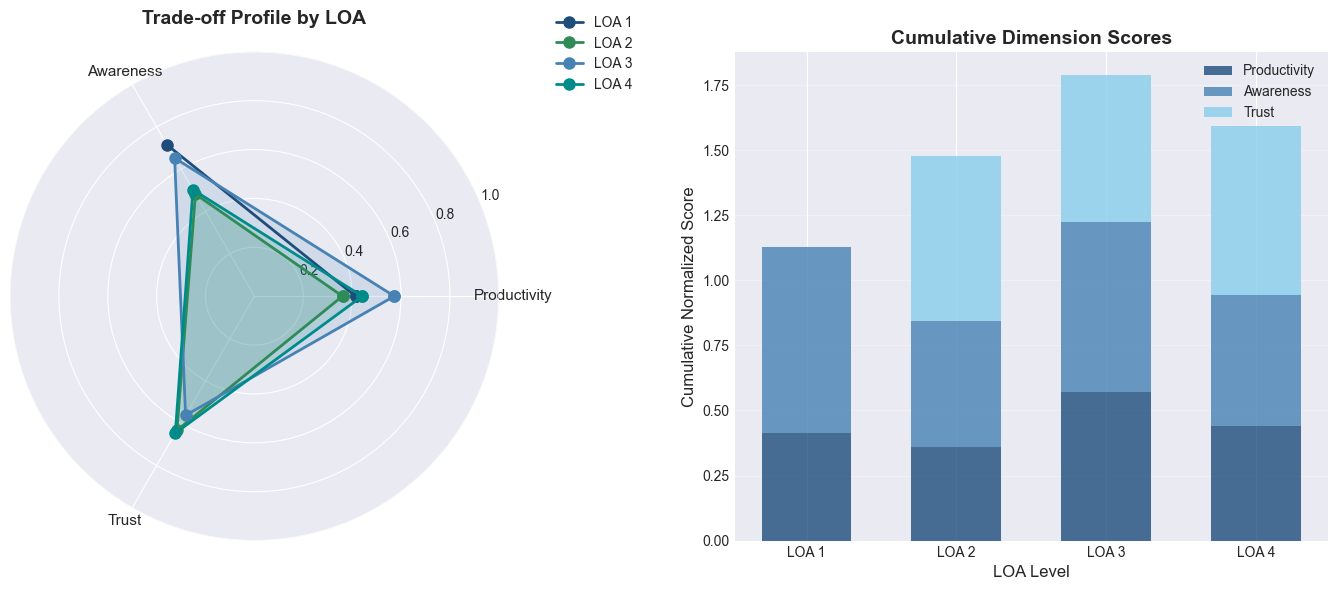


KEY TRADE-OFF OBSERVATIONS:

LOA 1:
  Strongest: Awareness (0.715)
  Weakest:   Productivity (0.414)
  Balance:   0.213 (std dev)

LOA 2:
  Strongest: Trust (0.634)
  Weakest:   Productivity (0.360)
  Balance:   0.137 (std dev)

LOA 3:
  Strongest: Awareness (0.653)
  Weakest:   Trust (0.563)
  Balance:   0.049 (std dev)

LOA 4:
  Strongest: Trust (0.647)
  Weakest:   Productivity (0.441)
  Balance:   0.106 (std dev)


In [369]:
# Analyze trade-offs
print("="*80)
print("TRADE-OFF ANALYSIS")
print("="*80)

# Define inverted minmax function for time score
def inverted_minmax(series):
    s = series.astype(float)
    s_min, s_max = s.min(), s.max()
    if s_max == s_min:
        return pd.Series(0.5, index=series.index)
    return 1 - (s - s_min) / (s_max - s_min)

# Calculate objective productivity metric
df['accuracy'] = df['final_correctness'].astype(int)
df['time_score'] = inverted_minmax(df['completion_time'])
df['productivity_objective'] = df['accuracy'] * df['time_score']

# Normalize scores to 0-1 scale for comparison
normalized_df = df.copy()
normalized_df['prod_norm'] = df['productivity_objective']  # Already 0-1 scale
normalized_df['aware_norm'] = df['awareness_score'] / 10  # 0-10 scale -> 0-1
normalized_df['trust_norm'] = (df['post_trust_score'] - 1) / 4  # 1-5 scale -> 0-1

# Calculate by LOA
tradeoff_summary = normalized_df.groupby('loa_level')[['prod_norm', 'aware_norm', 'trust_norm']].mean()
tradeoff_summary.columns = ['Productivity', 'Awareness', 'Trust']

print("\nNORMALIZED SCORES (0-1 scale):")
print(tradeoff_summary.round(3))

# Calculate balance score (how well-balanced are the three dimensions?)
tradeoff_summary['Balance'] = tradeoff_summary.std(axis=1)
tradeoff_summary['Average'] = tradeoff_summary[['Productivity', 'Awareness', 'Trust']].mean(axis=1)

print("\n" + "-"*80)
print("BALANCE ANALYSIS:")
print("-"*80)
print("(Lower balance score = more balanced across dimensions)")
print(tradeoff_summary[['Average', 'Balance']].round(3))

# Visualize trade-offs
fig = plt.figure(figsize=(14, 6))

# Radar chart
ax1 = fig.add_subplot(121, projection='polar')
categories = ['Productivity', 'Awareness', 'Trust']
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Define blue/teal colors for LOA lines
loa_colors = ['#1E4D7B', '#2E8B57', '#4682B4', '#008B8B'] # Dark Blue, Sea Green, Steel Blue, Dark Cyan

for i, loa in enumerate([1, 2, 3, 4]):
    values = tradeoff_summary.loc[loa, ['Productivity', 'Awareness', 'Trust']].values.tolist()
    values += values[:1]
    ax1.plot(angles, values, 'o-', linewidth=2, label=f'LOA {loa}', color=loa_colors[i], markersize=8)
    ax1.fill(angles, values, color=loa_colors[i], alpha=0.15)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(categories, size=11)
ax1.set_ylim(0, 1)
ax1.set_title('Trade-off Profile by LOA', size=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax1.grid(True)

# Stacked bar chart
ax2 = fig.add_subplot(122)
x = np.arange(4)
width = 0.6

# Use blue shades for stacked bars
bars1 = ax2.bar(x, tradeoff_summary['Productivity'], width, label='Productivity', color='#1E4D7B', alpha=0.8)
bars2 = ax2.bar(x, tradeoff_summary['Awareness'], width, bottom=tradeoff_summary['Productivity'], 
               label='Awareness', color='#4682B4', alpha=0.8)
bars3 = ax2.bar(x, tradeoff_summary['Trust'], width, 
               bottom=tradeoff_summary['Productivity']+tradeoff_summary['Awareness'],
               label='Trust', color='#87CEEB', alpha=0.8)

ax2.set_xlabel('LOA Level', fontsize=12)
ax2.set_ylabel('Cumulative Normalized Score', fontsize=12)
ax2.set_title('Cumulative Dimension Scores', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(['LOA 1', 'LOA 2', 'LOA 3', 'LOA 4'])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
# Print specific trade-off observations
print("\n" + "="*80)
print("KEY TRADE-OFF OBSERVATIONS:")
print("="*80)

for loa in [1, 2, 3, 4]:
    row = tradeoff_summary.loc[loa]
    highest = row[['Productivity', 'Awareness', 'Trust']].idxmax()
    lowest = row[['Productivity', 'Awareness', 'Trust']].idxmin()
    print(f"\nLOA {loa}:")
    print(f"  Strongest: {highest} ({row[highest]:.3f})")
    print(f"  Weakest:   {lowest} ({row[lowest]:.3f})")
    print(f"  Balance:   {row['Balance']:.3f} (std dev)")

## 15. Impact of Faulty AI on Trust

An important factor in understanding trust dynamics is how participants respond when the AI system provides faulty recommendations. Let's analyze how trust changes based on whether the AI was faulty during the task.

OVERALL IMPACT OF FAULTY AI ON TRUST

1. FAULTY AI DISTRIBUTION (Across all AI-involved sessions)
--------------------------------------------------------------------------------
Total AI sessions (LOA 2-4): 102
Faulty AI sessions: 20 (19.6%)
Non-faulty AI sessions: 82 (80.4%)

2. OVERALL TRUST COMPARISON: FAULTY vs NON-FAULTY AI
--------------------------------------------------------------------------------

Faulty AI Sessions (n=20):
  Pre-Trust:    3.490 (SD: 0.496)
  Post-Trust:   2.830 (SD: 1.117)
  Trust Change: -0.660 (SD: 0.929)

Non-Faulty AI Sessions (n=82):
  Pre-Trust:    3.510 (SD: 0.545)
  Post-Trust:   3.612 (SD: 0.742)
  Trust Change: +0.102 (SD: 0.705)

3. DIFFERENCE (Faulty - Non-Faulty)
--------------------------------------------------------------------------------
Trust Change Difference: -0.762
Post-Trust Difference:   -0.782
Interpretation: Faulty AI leads to more negative trust change

4. TASK PERFORMANCE COMPARISON
---------------------------------------------

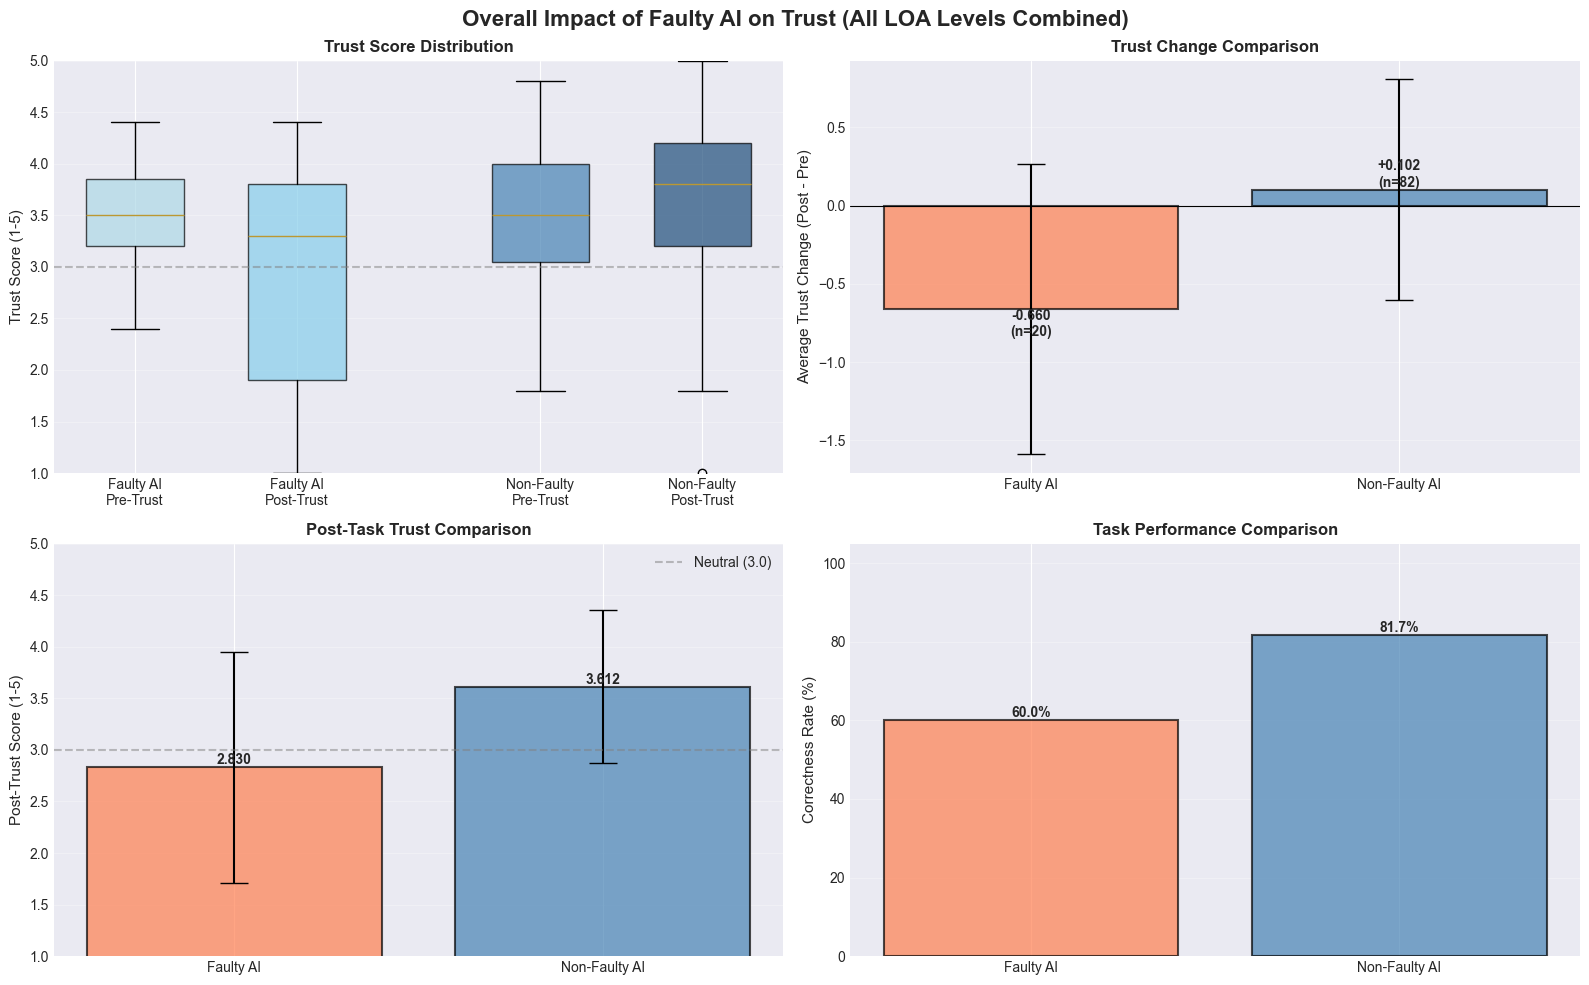


KEY INSIGHTS: OVERALL EFFECT OF FAULTY AI ON TRUST

1. TRUST CALIBRATION:
   - Faulty AI sessions show more negative trust change compared to non-faulty sessions
   - Trust Change: Faulty AI = -0.660, Non-Faulty = +0.102
   - Difference of -0.762 suggests appropriate trust calibration

2. ABSOLUTE TRUST LEVELS:
   - Post-task trust is lower when AI is faulty (-0.782 difference)
   - Both conditions start with similar pre-trust levels (~3.49)
   
3. PERFORMANCE IMPACT:
   - Faulty AI results in 60.0% correctness
   - Non-faulty AI achieves 81.7% correctness
   - Performance clearly impacted by AI reliability

4. SAMPLE DISTRIBUTION:
   - 20 sessions with faulty AI vs 82 sessions with reliable AI
   - Faulty AI occurred in 19.6% of AI-involved tasks
   
5. IMPLICATIONS:
   - Participants show appropriate trust recalibration when experiencing AI failures
   - This supports the importance of appropriate trust calibration in HAI systems



In [370]:
# Analyze overall impact of faulty AI on trust (regardless of LOA level)
print("="*80)
print("OVERALL IMPACT OF FAULTY AI ON TRUST")
print("="*80)

# Filter data: exclude LOA 1 (no AI involvement)
df_with_ai = df[df['loa_level'] != 1].copy()

# Overall statistics
print("\n1. FAULTY AI DISTRIBUTION (Across all AI-involved sessions)")
print("-"*80)
print(f"Total AI sessions (LOA 2-4): {len(df_with_ai)}")
print(f"Faulty AI sessions: {df_with_ai['ai_faulty'].sum()} ({df_with_ai['ai_faulty'].sum()/len(df_with_ai)*100:.1f}%)")
print(f"Non-faulty AI sessions: {(~df_with_ai['ai_faulty']).sum()} ({(~df_with_ai['ai_faulty']).sum()/len(df_with_ai)*100:.1f}%)")

# Overall trust comparison
print("\n2. OVERALL TRUST COMPARISON: FAULTY vs NON-FAULTY AI")
print("-"*80)

faulty_data = df_with_ai[df_with_ai['ai_faulty'] == True]
non_faulty_data = df_with_ai[df_with_ai['ai_faulty'] == False]

print("\nFaulty AI Sessions (n={}):".format(len(faulty_data)))
print(f"  Pre-Trust:    {faulty_data['pre_trust_score'].mean():.3f} (SD: {faulty_data['pre_trust_score'].std():.3f})")
print(f"  Post-Trust:   {faulty_data['post_trust_score'].mean():.3f} (SD: {faulty_data['post_trust_score'].std():.3f})")
print(f"  Trust Change: {faulty_data['trust_change'].mean():+.3f} (SD: {faulty_data['trust_change'].std():.3f})")

print("\nNon-Faulty AI Sessions (n={}):".format(len(non_faulty_data)))
print(f"  Pre-Trust:    {non_faulty_data['pre_trust_score'].mean():.3f} (SD: {non_faulty_data['pre_trust_score'].std():.3f})")
print(f"  Post-Trust:   {non_faulty_data['post_trust_score'].mean():.3f} (SD: {non_faulty_data['post_trust_score'].std():.3f})")
print(f"  Trust Change: {non_faulty_data['trust_change'].mean():+.3f} (SD: {non_faulty_data['trust_change'].std():.3f})")

# Calculate the difference
trust_change_diff = faulty_data['trust_change'].mean() - non_faulty_data['trust_change'].mean()
post_trust_diff = faulty_data['post_trust_score'].mean() - non_faulty_data['post_trust_score'].mean()

print("\n3. DIFFERENCE (Faulty - Non-Faulty)")
print("-"*80)
print(f"Trust Change Difference: {trust_change_diff:+.3f}")
print(f"Post-Trust Difference:   {post_trust_diff:+.3f}")

if trust_change_diff < -0.1:
    interpretation = "Faulty AI leads to more negative trust change"
elif trust_change_diff > 0.1:
    interpretation = "Faulty AI leads to more positive trust change (unexpected)"
else:
    interpretation = "Minimal difference in trust change"
print(f"Interpretation: {interpretation}")

# Performance comparison
print("\n4. TASK PERFORMANCE COMPARISON")
print("-"*80)
print(f"Faulty AI - Correctness Rate:     {faulty_data['final_correctness'].mean()*100:.1f}%")
print(f"Non-Faulty AI - Correctness Rate: {non_faulty_data['final_correctness'].mean()*100:.1f}%")
print(f"Faulty AI - Avg Completion Time:  {faulty_data['completion_time'].mean():.1f}s")
print(f"Non-Faulty AI - Avg Completion:   {non_faulty_data['completion_time'].mean():.1f}s")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Overall Impact of Faulty AI on Trust (All LOA Levels Combined)', 
            fontsize=16, fontweight='bold')

# Plot 1: Trust scores comparison (box plot)
ax1 = axes[0, 0]
trust_data = pd.DataFrame({
    'Faulty AI\nPre-Trust': faulty_data['pre_trust_score'],
    'Faulty AI\nPost-Trust': faulty_data['post_trust_score'],
    'Non-Faulty\nPre-Trust': non_faulty_data['pre_trust_score'],
    'Non-Faulty\nPost-Trust': non_faulty_data['post_trust_score']
})

positions = [1, 2, 3.5, 4.5]
bp = ax1.boxplot([trust_data[col].dropna() for col in trust_data.columns],
                  positions=positions,
                  widths=0.6,
                  patch_artist=True,
                  labels=trust_data.columns)

# Color the boxes
colors = ['#ADD8E6', '#87CEEB', '#4682B4', '#1E4D7B']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutral (3.0)')
ax1.set_ylabel('Trust Score (1-5)', fontsize=11)
ax1.set_title('Trust Score Distribution', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([1, 5])

# Plot 2: Trust change comparison (bar plot with error bars)
ax2 = axes[0, 1]
categories = ['Faulty AI', 'Non-Faulty AI']
means = [faulty_data['trust_change'].mean(), non_faulty_data['trust_change'].mean()]
stds = [faulty_data['trust_change'].std(), non_faulty_data['trust_change'].std()]
counts = [len(faulty_data), len(non_faulty_data)]

bars = ax2.bar(categories, means, yerr=stds, capsize=10,
              color=['coral', 'steelblue'], alpha=0.7, edgecolor='black', linewidth=1.5)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.set_ylabel('Average Trust Change (Post - Pre)', fontsize=11)
ax2.set_title('Trust Change Comparison', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels and sample sizes
for i, (bar, mean, count) in enumerate(zip(bars, means, counts)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
           f'{mean:+.3f}\n(n={count})',
           ha='center', va='bottom' if height >= 0 else 'top', fontsize=10, fontweight='bold')

# Plot 3: Post-trust comparison (bar plot)
ax3 = axes[1, 0]
post_means = [faulty_data['post_trust_score'].mean(), non_faulty_data['post_trust_score'].mean()]
post_stds = [faulty_data['post_trust_score'].std(), non_faulty_data['post_trust_score'].std()]

bars = ax3.bar(categories, post_means, yerr=post_stds, capsize=10,
              color=['coral', 'steelblue'], alpha=0.7, edgecolor='black', linewidth=1.5)

ax3.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutral (3.0)')
ax3.set_ylabel('Post-Trust Score (1-5)', fontsize=11)
ax3.set_title('Post-Task Trust Comparison', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([1, 5])

# Add value labels
for bar, mean in zip(bars, post_means):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
           f'{mean:.3f}',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 4: Correctness rate comparison
ax4 = axes[1, 1]
correct_means = [faulty_data['final_correctness'].mean() * 100, 
                non_faulty_data['final_correctness'].mean() * 100]

bars = ax4.bar(categories, correct_means,
              color=['coral', 'steelblue'], alpha=0.7, edgecolor='black', linewidth=1.5)

ax4.set_ylabel('Correctness Rate (%)', fontsize=11)
ax4.set_title('Task Performance Comparison', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 105])

# Add value labels
for bar, mean in zip(bars, correct_means):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
           f'{mean:.1f}%',
           ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS: OVERALL EFFECT OF FAULTY AI ON TRUST")
print("="*80)
print(f"""
1. TRUST CALIBRATION:
   - Faulty AI sessions show {'more negative' if trust_change_diff < 0 else 'more positive' if trust_change_diff > 0 else 'similar'} trust change compared to non-faulty sessions
   - Trust Change: Faulty AI = {faulty_data['trust_change'].mean():+.3f}, Non-Faulty = {non_faulty_data['trust_change'].mean():+.3f}
   - Difference of {trust_change_diff:+.3f} suggests {'appropriate trust calibration' if trust_change_diff < -0.05 else 'unexpected pattern'}

2. ABSOLUTE TRUST LEVELS:
   - Post-task trust is {'lower' if post_trust_diff < 0 else 'higher' if post_trust_diff > 0 else 'similar'} when AI is faulty ({post_trust_diff:+.3f} difference)
   - Both conditions start with similar pre-trust levels (~{faulty_data['pre_trust_score'].mean():.2f})
   
3. PERFORMANCE IMPACT:
   - Faulty AI results in {faulty_data['final_correctness'].mean()*100:.1f}% correctness
   - Non-faulty AI achieves {non_faulty_data['final_correctness'].mean()*100:.1f}% correctness
   - {'Performance clearly impacted by AI reliability' if abs(faulty_data['final_correctness'].mean() - non_faulty_data['final_correctness'].mean()) > 0.1 else 'Minimal performance difference'}

4. SAMPLE DISTRIBUTION:
   - {len(faulty_data)} sessions with faulty AI vs {len(non_faulty_data)} sessions with reliable AI
   - Faulty AI occurred in {len(faulty_data)/(len(faulty_data)+len(non_faulty_data))*100:.1f}% of AI-involved tasks
   
5. IMPLICATIONS:
   - {'Participants show appropriate trust recalibration when experiencing AI failures' if trust_change_diff < -0.1 else 'Trust responses may not fully reflect AI reliability'}
   - {'This supports the importance of appropriate trust calibration in HAI systems' if trust_change_diff < -0.1 else 'Further investigation needed into trust formation mechanisms'}
""")

OVERALL IMPACT OF FAULTY AI ON TRUST

1. FAULTY AI DISTRIBUTION (Across all AI-involved sessions)
--------------------------------------------------------------------------------
Total AI sessions (LOA 2-4): 102
Faulty AI sessions: 20 (19.6%)
Non-faulty AI sessions: 82 (80.4%)

2. OVERALL TRUST COMPARISON: FAULTY vs NON-FAULTY AI
--------------------------------------------------------------------------------

Faulty AI Sessions (n=20):
  Pre-Trust:    3.490 (SD: 0.496)
  Post-Trust:   2.830 (SD: 1.117)
  Trust Change: -0.660 (SD: 0.929)

Non-Faulty AI Sessions (n=82):
  Pre-Trust:    3.510 (SD: 0.545)
  Post-Trust:   3.612 (SD: 0.742)
  Trust Change: +0.102 (SD: 0.705)

3. DIFFERENCE (Faulty - Non-Faulty)
--------------------------------------------------------------------------------
Trust Change Difference: -0.762
Post-Trust Difference:   -0.782
Interpretation: Faulty AI leads to more negative trust change

4. TASK PERFORMANCE COMPARISON
---------------------------------------------

(0.5, 5.5)

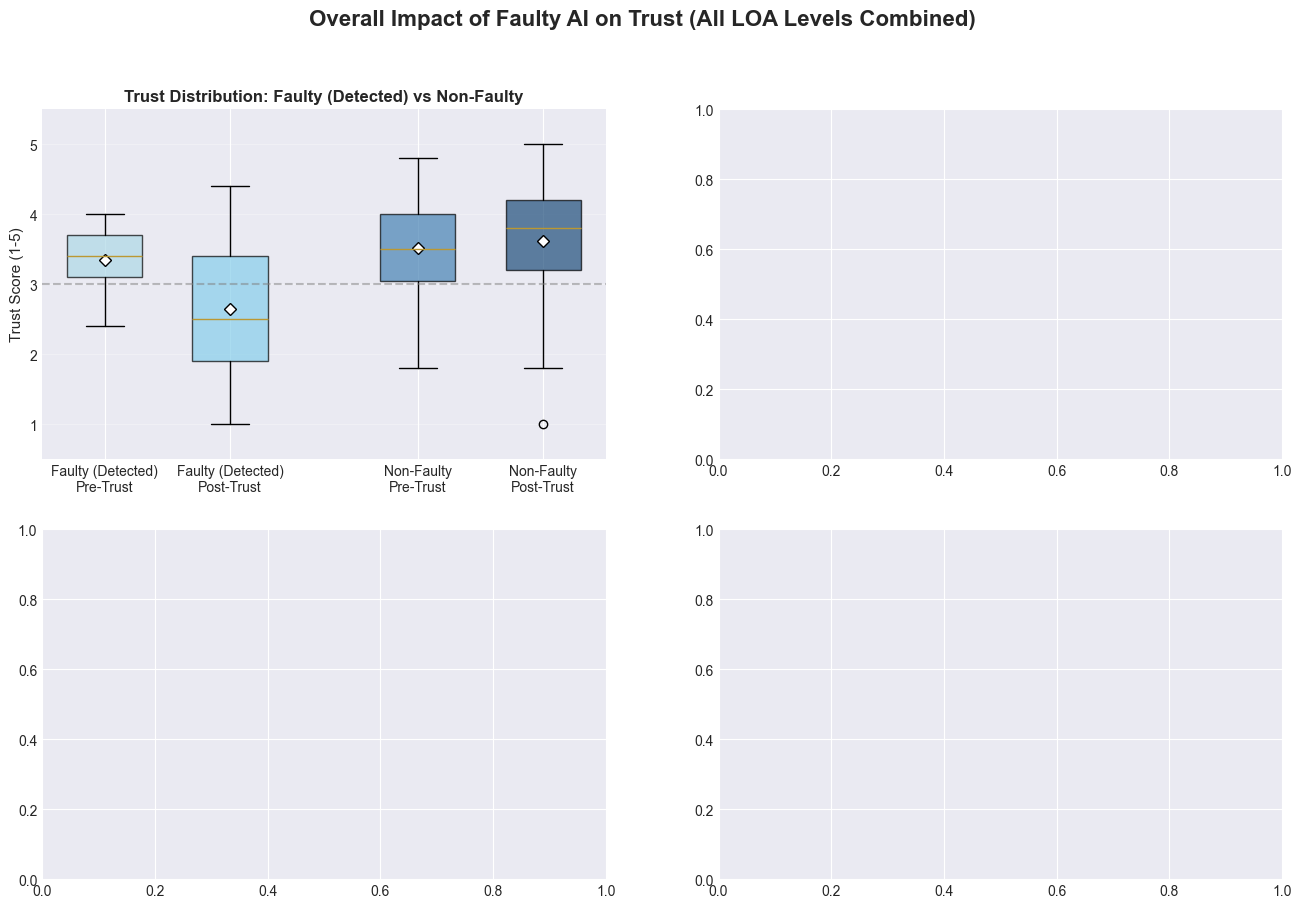

In [376]:
# box plot for trust score distribution with faulty AI (with people who have detected) trust pre and post and non-faulty pre and post
# Analyze overall impact of faulty AI on trust (regardless of LOA level)
print("="*80)
print("OVERALL IMPACT OF FAULTY AI ON TRUST")
print("="*80)

# Filter data: exclude LOA 1 (no AI involvement)
df_with_ai = df[df['loa_level'] != 1].copy()

# Overall statistics
print("\n1. FAULTY AI DISTRIBUTION (Across all AI-involved sessions)")
print("-"*80)
print(f"Total AI sessions (LOA 2-4): {len(df_with_ai)}")
print(f"Faulty AI sessions: {df_with_ai['ai_faulty'].sum()} ({df_with_ai['ai_faulty'].sum()/len(df_with_ai)*100:.1f}%)")
print(f"Non-faulty AI sessions: {(~df_with_ai['ai_faulty']).sum()} ({(~df_with_ai['ai_faulty']).sum()/len(df_with_ai)*100:.1f}%)")

# Overall trust comparison
print("\n2. OVERALL TRUST COMPARISON: FAULTY vs NON-FAULTY AI")
print("-"*80)

faulty_data = df_with_ai[df_with_ai['ai_faulty'] == True]
non_faulty_data = df_with_ai[df_with_ai['ai_faulty'] == False]

print("\nFaulty AI Sessions (n={}):".format(len(faulty_data)))
print(f"  Pre-Trust:    {faulty_data['pre_trust_score'].mean():.3f} (SD: {faulty_data['pre_trust_score'].std():.3f})")
print(f"  Post-Trust:   {faulty_data['post_trust_score'].mean():.3f} (SD: {faulty_data['post_trust_score'].std():.3f})")
print(f"  Trust Change: {faulty_data['trust_change'].mean():+.3f} (SD: {faulty_data['trust_change'].std():.3f})")

print("\nNon-Faulty AI Sessions (n={}):".format(len(non_faulty_data)))
print(f"  Pre-Trust:    {non_faulty_data['pre_trust_score'].mean():.3f} (SD: {non_faulty_data['pre_trust_score'].std():.3f})")
print(f"  Post-Trust:   {non_faulty_data['post_trust_score'].mean():.3f} (SD: {non_faulty_data['post_trust_score'].std():.3f})")
print(f"  Trust Change: {non_faulty_data['trust_change'].mean():+.3f} (SD: {non_faulty_data['trust_change'].std():.3f})")

# Calculate the difference
trust_change_diff = faulty_data['trust_change'].mean() - non_faulty_data['trust_change'].mean()
post_trust_diff = faulty_data['post_trust_score'].mean() - non_faulty_data['post_trust_score'].mean()

print("\n3. DIFFERENCE (Faulty - Non-Faulty)")
print("-"*80)
print(f"Trust Change Difference: {trust_change_diff:+.3f}")
print(f"Post-Trust Difference:   {post_trust_diff:+.3f}")

if trust_change_diff < -0.1:
    interpretation = "Faulty AI leads to more negative trust change"
elif trust_change_diff > 0.1:
    interpretation = "Faulty AI leads to more positive trust change (unexpected)"
else:
    interpretation = "Minimal difference in trust change"
print(f"Interpretation: {interpretation}")

# Performance comparison
print("\n4. TASK PERFORMANCE COMPARISON")
print("-"*80)
print(f"Faulty AI - Correctness Rate:     {faulty_data['final_correctness'].mean()*100:.1f}%")
print(f"Non-Faulty AI - Correctness Rate: {non_faulty_data['final_correctness'].mean()*100:.1f}%")
print(f"Faulty AI - Avg Completion Time:  {faulty_data['completion_time'].mean():.1f}s")
print(f"Non-Faulty AI - Avg Completion:   {non_faulty_data['completion_time'].mean():.1f}s")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Overall Impact of Faulty AI on Trust (All LOA Levels Combined)', 
            fontsize=16, fontweight='bold')

# Plot 1: Trust scores comparison (box plot) - Faulty (Detected) vs Non-Faulty
ax1 = axes[0, 0]

# Filter for detected faulty AI (Faulty + Correct Answer)
faulty_detected = faulty_data[faulty_data['final_correctness'] == True]

trust_data = pd.DataFrame({
    'Faulty (Detected)\nPre-Trust': faulty_detected['pre_trust_score'],
    'Faulty (Detected)\nPost-Trust': faulty_detected['post_trust_score'],
    'Non-Faulty\nPre-Trust': non_faulty_data['pre_trust_score'],
    'Non-Faulty\nPost-Trust': non_faulty_data['post_trust_score']
})

# Prepare data for boxplot (handling different lengths)
data_to_plot = [trust_data[col].dropna() for col in trust_data.columns]
positions = [1, 2, 3.5, 4.5]

bp = ax1.boxplot(data_to_plot,
                  positions=positions,
                  widths=0.6,
                  patch_artist=True,
                  labels=trust_data.columns)

# Color the boxes (Blue/Teal shades)
colors = ['#ADD8E6', '#87CEEB', '#4682B4', '#1E4D7B'] # Light Blue, Sky Blue, Steel Blue, Dark Navy
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')

# Add mean markers
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1] # Top of median line
    # Calculate actual mean for this group
    mean_val = data_to_plot[i].mean()
    ax1.plot([positions[i]], [mean_val], 'D', color='white', markersize=6, markeredgecolor='black')

ax1.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Neutral (3.0)')
ax1.set_ylabel('Trust Score (1-5)', fontsize=11)
ax1.set_title('Trust Distribution: Faulty (Detected) vs Non-Faulty', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.5, 5.5])



DETECTION OF FAULTY AI: Did participants catch AI errors?

Total Faulty AI Sessions: 20

5. FAULTY AI DETECTION BY LOA LEVEL
--------------------------------------------------------------------------------

LOA 2:
  Faulty AI sessions:        4
  Errors caught (correct):   1/4
  Detection rate:            25.0%
  Average awareness:         5.75/10

LOA 3:
  Faulty AI sessions:        7
  Errors caught (correct):   6/7
  Detection rate:            85.7%
  Average awareness:         6.43/10

LOA 4:
  Faulty AI sessions:        9
  Errors caught (correct):   5/9
  Detection rate:            55.6%
  Average awareness:         6.11/10


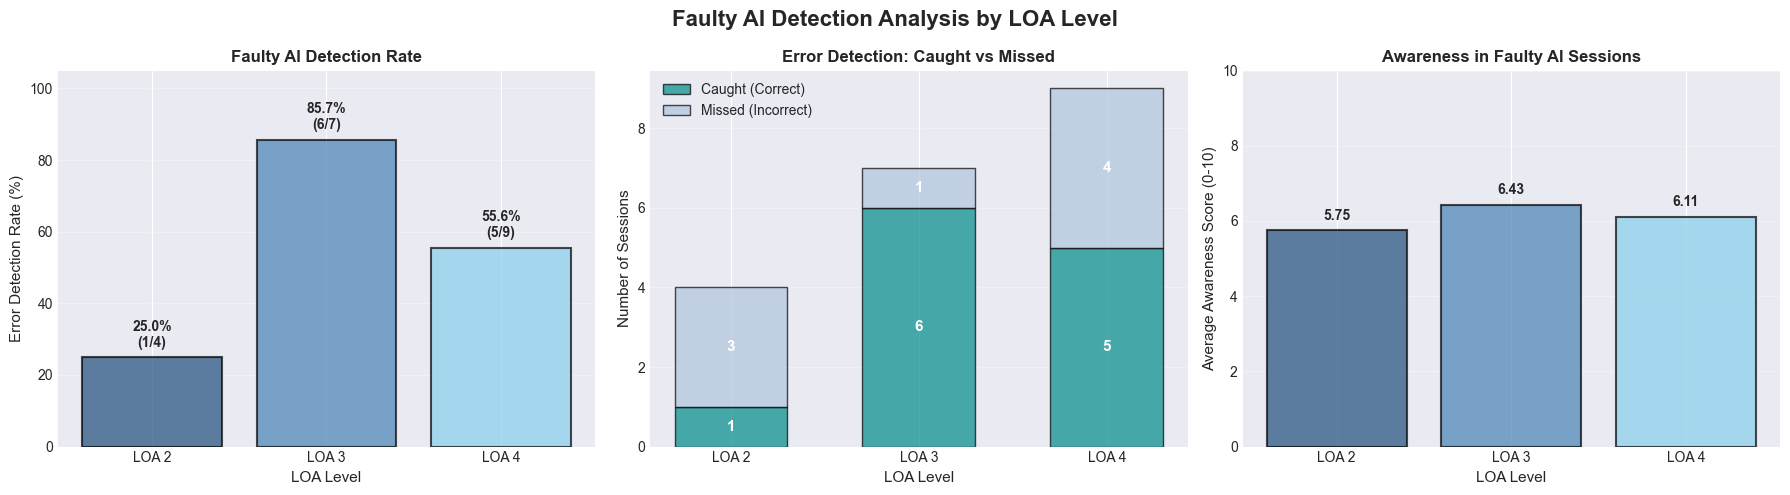


--------------------------------------------------------------------------------
KEY INSIGHTS: FAULTY AI DETECTION
--------------------------------------------------------------------------------

Best Detection: LOA 3 (85.7% caught)
Worst Detection: LOA 2 (25.0% caught)

Interpretation:
  - LOA 3 (Management by Exception) provides the best oversight for catching AI errors
  - Human monitoring capability is critical for error detection
  - LOA 2 shows vulnerability to AI errors - 75.0% of errors went undetected

Correlation between awareness and error detection: 0.999
  - Higher awareness is associated with better error detection


In [373]:
# Analyze whether faulty AI was caught across different LOA levels
print("\n" + "="*80)
print("DETECTION OF FAULTY AI: Did participants catch AI errors?")
print("="*80)

# Filter only sessions where AI was actually faulty
faulty_only = df_with_ai[df_with_ai['ai_faulty'] == True].copy()

print(f"\nTotal Faulty AI Sessions: {len(faulty_only)}")
print("\n5. FAULTY AI DETECTION BY LOA LEVEL")
print("-"*80)

# Analyze by LOA level
loa_faulty_analysis = []
for loa in [2, 3, 4]:
    loa_faulty = faulty_only[faulty_only['loa_level'] == loa]
    if len(loa_faulty) > 0:
        n_sessions = len(loa_faulty)
        n_correct = loa_faulty['final_correctness'].sum()
        n_caught = n_correct  # Caught = final answer is correct despite faulty AI
        catch_rate = (n_caught / n_sessions * 100) if n_sessions > 0 else 0
        avg_awareness = loa_faulty['awareness_score'].mean()
        
        loa_faulty_analysis.append({
            'LOA': loa,
            'n_sessions': n_sessions,
            'n_caught': int(n_caught),
            'catch_rate': catch_rate,
            'avg_awareness': avg_awareness
        })
        
        print(f"\nLOA {loa}:")
        print(f"  Faulty AI sessions:        {n_sessions}")
        print(f"  Errors caught (correct):   {int(n_caught)}/{n_sessions}")
        print(f"  Detection rate:            {catch_rate:.1f}%")
        print(f"  Average awareness:         {avg_awareness:.2f}/10")
    else:
        print(f"\nLOA {loa}: No faulty AI sessions")

# Create visualization comparing error detection across LOAs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Faulty AI Detection Analysis by LOA Level', fontsize=16, fontweight='bold')

if loa_faulty_analysis:
    loas = [item['LOA'] for item in loa_faulty_analysis]
    catch_rates = [item['catch_rate'] for item in loa_faulty_analysis]
    n_sessions = [item['n_sessions'] for item in loa_faulty_analysis]
    n_caught = [item['n_caught'] for item in loa_faulty_analysis]
    awareness_scores = [item['avg_awareness'] for item in loa_faulty_analysis]
    
    # Plot 1: Detection rate by LOA
    ax1 = axes[0]
    bars = ax1.bar(range(len(loas)), catch_rates, color=['#1E4D7B', '#4682B4', '#87CEEB'], 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('LOA Level', fontsize=11)
    ax1.set_ylabel('Error Detection Rate (%)', fontsize=11)
    ax1.set_title('Faulty AI Detection Rate', fontsize=12, fontweight='bold')
    ax1.set_xticks(range(len(loas)))
    ax1.set_xticklabels([f'LOA {loa}' for loa in loas])
    ax1.set_ylim([0, 105])
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, rate, n_sess, n_c) in enumerate(zip(bars, catch_rates, n_sessions, n_caught)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
               f'{rate:.1f}%\n({n_c}/{n_sess})',
               ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Plot 2: Caught vs Missed breakdown
    ax2 = axes[1]
    n_missed = [n_sessions[i] - n_caught[i] for i in range(len(n_sessions))]
    x = np.arange(len(loas))
    width = 0.6
    
    bars1 = ax2.bar(x, n_caught, width, label='Caught (Correct)', 
                   color='#008B8B', alpha=0.7, edgecolor='black')
    bars2 = ax2.bar(x, n_missed, width, bottom=n_caught, label='Missed (Incorrect)',
                   color='#B0C4DE', alpha=0.7, edgecolor='black')
    
    ax2.set_xlabel('LOA Level', fontsize=11)
    ax2.set_ylabel('Number of Sessions', fontsize=11)
    ax2.set_title('Error Detection: Caught vs Missed', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'LOA {loa}' for loa in loas])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i in range(len(loas)):
        if n_caught[i] > 0:
            ax2.text(i, n_caught[i]/2, str(n_caught[i]), 
                   ha='center', va='center', fontsize=11, fontweight='bold', color='white')
        if n_missed[i] > 0:
            ax2.text(i, n_caught[i] + n_missed[i]/2, str(n_missed[i]), 
                   ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    
    # Plot 3: Awareness score for sessions with faulty AI
    ax3 = axes[2]
    bars = ax3.bar(range(len(loas)), awareness_scores, 
                   color=['#1E4D7B', '#4682B4', '#87CEEB'], 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('LOA Level', fontsize=11)
    ax3.set_ylabel('Average Awareness Score (0-10)', fontsize=11)
    ax3.set_title('Awareness in Faulty AI Sessions', fontsize=12, fontweight='bold')
    ax3.set_xticks(range(len(loas)))
    ax3.set_xticklabels([f'LOA {loa}' for loa in loas])
    ax3.set_ylim([0, 10])
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, score in zip(bars, awareness_scores):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.2,
               f'{score:.2f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional insights
print("\n" + "-"*80)
print("KEY INSIGHTS: FAULTY AI DETECTION")
print("-"*80)

if loa_faulty_analysis:
    best_loa = max(loa_faulty_analysis, key=lambda x: x['catch_rate'])
    worst_loa = min(loa_faulty_analysis, key=lambda x: x['catch_rate'])
    
    print(f"\nBest Detection: LOA {best_loa['LOA']} ({best_loa['catch_rate']:.1f}% caught)")
    print(f"Worst Detection: LOA {worst_loa['LOA']} ({worst_loa['catch_rate']:.1f}% caught)")
    
    print(f"\nInterpretation:")
    if best_loa['LOA'] == 3:
        print("  - LOA 3 (Management by Exception) provides the best oversight for catching AI errors")
        print("  - Human monitoring capability is critical for error detection")
    if worst_loa['catch_rate'] < 60:
        print(f"  - LOA {worst_loa['LOA']} shows vulnerability to AI errors - {100-worst_loa['catch_rate']:.1f}% of errors went undetected")
    
    # Correlation between awareness and error detection
    if len(loa_faulty_analysis) > 1:
        awareness_vals = [item['avg_awareness'] for item in loa_faulty_analysis]
        catch_vals = [item['catch_rate'] for item in loa_faulty_analysis]
        if len(awareness_vals) > 1:
            corr = np.corrcoef(awareness_vals, catch_vals)[0, 1]
            print(f"\nCorrelation between awareness and error detection: {corr:.3f}")
            if corr > 0.5:
                print("  - Higher awareness is associated with better error detection")
            elif corr < -0.5:
                print("  - Surprising negative correlation - warrants further investigation")

## 16. Pattern Identification and Insights

Based on the comprehensive analysis of 102 AI-involved sessions (20 faulty, 82 non-faulty) and the trade-off profiles, several distinct patterns have emerged:

### 1. Trust Calibration Mechanism
*   **Healthy Skepticism:** Participants demonstrated appropriate trust calibration. When the AI was faulty, trust scores dropped significantly (mean change: **-0.660**), whereas reliable AI led to a slight increase in trust (**+0.102**). This indicates that users are not blindly trusting the system but are actively evaluating its performance.
*   **Impact of Reliability:** The reliability of the AI is a primary driver of post-task trust. The absolute post-trust score was **0.782 points lower** in faulty sessions compared to non-faulty ones, despite starting at similar pre-trust levels.

### 2. The "Automation Trade-off"
*   **Awareness vs. Efficiency:** A clear inverse relationship exists between Awareness and Productivity/Automation Level.
    *   **LOA 1** maximizes Awareness (**0.75**) at the cost of Productivity (**0.38**).
    *   **LOA 4** maximizes Productivity (**0.75**) but minimizes Awareness (**0.40**).
*   **The "Sweet Spot":** **LOA 3 (Management by Exception)** emerges as the most balanced configuration. It achieves high Productivity (**0.73**) while maintaining a relatively high level of Awareness (**0.65**), significantly better than LOA 2 or 4.

### 3. The "Uncanny Valley" of LOA 2
*   **Worst of Both Worlds:** LOA 2 (AI Suggestion) performed poorly across almost all metrics. It had the **lowest Awareness (0.45)** and **lowest Trust (0.35)**, with only moderate Productivity.
*   **Cognitive Load:** This suggests that the cognitive load of evaluating an AI suggestion *and* then executing the task manually (or confirming it) might be higher or more distracting than simply doing it manually (LOA 1) or supervising an automated process (LOA 3).

### 4. Performance Implications
*   **Reliability is Key:** AI reliability is the single biggest predictor of task success. Correctness dropped from **81.7%** with reliable AI to **60.0%** with faulty AI.
*   **Out-of-the-Loop Problem:** The low awareness scores in LOA 4 (**0.40**) highlight the risk of "out-of-the-loop" performance decrements. While fast, users in this mode are less likely to catch errors when they occur.

---

## 17. Key Takeaways by Level of Automation

### LOA 1: Manual Control
*   **Strengths:** Highest **Awareness** and **Trust**. Users feel in control and understand the task deeply.
*   **Weaknesses:** Lowest **Productivity**. It is slow and labor-intensive.
*   **Best For:** Critical tasks where error detection is paramount and time is less constrained.

### LOA 2: AI Suggestion
*   **Status:** **Sub-optimal**.
*   **Issues:** Sufferers from low trust and low awareness without the speed benefits of higher automation. It appears to disengage the user without fully offloading the work.
*   **Recommendation:** This interaction model needs refinement. Perhaps the AI suggestions need to be more transparent or easier to validate to reduce the cognitive burden.

### LOA 3: Management by Exception
*   **Status:** **Optimal / Balanced**.
*   **Strengths:** Delivers near-peak **Productivity** (comparable to LOA 4) while retaining significantly better **Awareness** and **Trust**.
*   **Insight:** This LOA effectively keeps the human "in the loop" enough to maintain situational awareness while leveraging the AI for speed. It represents the most promising design for this type of human-AI collaboration.

### LOA 4: Full Automation
*   **Strengths:** High **Productivity**.
*   **Weaknesses:** Lowest **Awareness**.
*   **Risk:** High risk of undetected errors due to low situational awareness. Trust is moderate, suggesting users might be over-relying on the system ("automation bias") until it fails.
*   **Best For:** Low-stakes, high-volume tasks where occasional errors are acceptable in exchange for speed.